In [31]:
from pymoo.problems.many.dtlz import DTLZ2
from pymoo.util.ref_dirs import get_reference_directions
import pandas as pd
from pymoo.indicators.hv import Hypervolume
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from pymoo.operators.sampling.lhs import LHS
import matplotlib.pyplot as plt
from pymoo.util.display.output import Output, pareto_front_if_possible
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np
import random

In [2]:
problem = DTLZ2(n_obj=2)
sampling  = LHS()
ref_dirs = sampling(problem,100).get('X')

In [3]:
ref_dirs

array([[1.01727672e-01, 7.04816855e-02, 5.39099917e-01, 8.66016094e-01,
        5.45503304e-01, 9.26404103e-01, 7.27548896e-01, 3.01815894e-01,
        5.34057186e-01, 9.65322487e-02],
       [6.32156678e-01, 2.22615042e-01, 5.75841699e-01, 1.47482273e-01,
        9.92915061e-01, 8.26142905e-01, 9.24221491e-01, 4.95149437e-01,
        4.70679050e-01, 9.27196459e-01],
       [8.05533564e-01, 7.03433578e-01, 8.50955483e-01, 1.29348256e-01,
        6.88048401e-01, 4.01156730e-01, 6.90090777e-01, 3.90682788e-01,
        6.36862324e-01, 2.38465345e-01],
       [2.04729320e-01, 7.19944394e-01, 1.08544182e-01, 4.66710626e-01,
        3.97358066e-01, 1.43152617e-01, 2.41094914e-01, 2.38709703e-01,
        4.56809827e-01, 3.82348672e-01],
       [3.65807185e-01, 6.30628223e-01, 1.17136114e-01, 2.53489040e-01,
        5.18863634e-01, 6.31332837e-01, 2.01457260e-01, 3.77904772e-01,
        1.35651973e-01, 9.54269921e-01],
       [3.34304808e-01, 6.93525809e-01, 6.33953652e-01, 2.28652456e-01,
   

In [4]:
output = {}
problem._evaluate(ref_dirs,output)

In [5]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,11):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']


In [6]:
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Objective 1,Objective 2
0,0.101728,0.070482,0.539100,0.866016,0.545503,0.926404,0.727549,0.301816,0.534057,0.096532,1.736467,0.279862
1,0.632157,0.222615,0.575842,0.147482,0.992915,0.826143,0.924221,0.495149,0.470679,0.927196,1.048486,1.608012
2,0.805534,0.703434,0.850955,0.129348,0.688048,0.401157,0.690091,0.390683,0.636862,0.238465,0.445781,1.413666
3,0.204729,0.719944,0.108544,0.466711,0.397358,0.143153,0.241095,0.238710,0.456810,0.382349,1.415141,0.471458
4,0.365807,0.630628,0.117136,0.253489,0.518864,0.631333,0.201457,0.377905,0.135652,0.954270,1.414537,0.915898


##### MOdelling on Objective 1

In [11]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [12]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
kernel =  RBF(length_scale=3) 
model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=25,normalize_y=True).fit(X,Y)

In [9]:
#x1 = dataset['x1'].to_numpy()
#x2= dataset['x2'].to_numpy()
#x1 = np.linspace(x1.min(), x2.max())
#x2 = np.linspace(x2.min(), x1.max())

In [13]:
#x= (np.array([x1,x2])).T
#output = {}
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

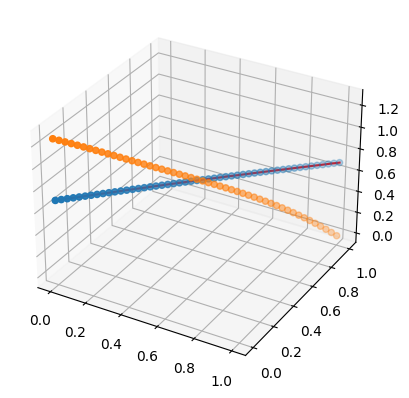

In [14]:
#ax = plt.figure().add_subplot(projection='3d')
#mean,std = model.predict(x,return_std=True)
#ax.scatter(x1,x2,mean)
#ax.scatter(x1,x2,data)
#ax.plot(x1,x2,mean,color = 'red')


In [14]:
kernel_2 = C(1.0) * RBF(length_scale=0.1) 
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

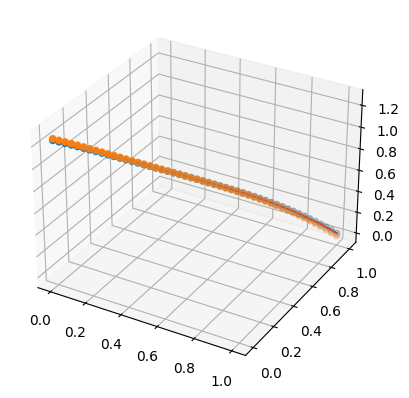

In [16]:
#x1 = dataset['x1'].to_numpy()
#x2= dataset['x2'].to_numpy()
#x1 = np.linspace(x1.min(), x2.max())
#x2 = np.linspace(x2.min(), x1.max())
#ax = plt.figure().add_subplot(projection='3d')
#x= (np.array([x1,x2])).T
#mean_2,std_2 = model_2.predict(x,return_std=True)
#ax.scatter(x1,x2,mean_2)
#ax.scatter(x1,x2,data)
#ax.plot(x1,x2,mean_2,color = 'red')


#### Model on Objective 2

In [16]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) 
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=12).fit(X,Y)

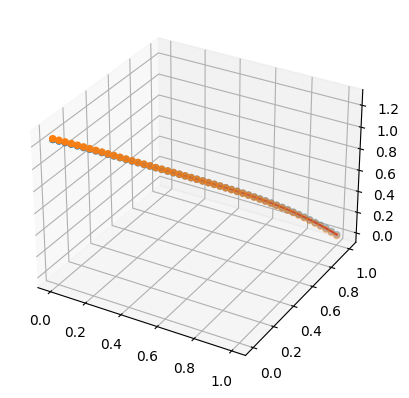

In [18]:
#x1 = dataset['x1'].to_numpy()
#x2= dataset['x2'].to_numpy()
#x1 = np.linspace(x1.min(), x2.max())
#x2 = np.linspace(x2.min(), x1.max())
#ax = plt.figure().add_subplot(projection='3d')
#x= (np.array([x1,x2])).T
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]
#mean_2,std_2 = model_3.predict(x,return_std=True)
#ax.scatter(x1,x2,mean_2)
#ax.scatter(x1,x2,data)
#ax.plot(x1,x2,mean_2,color = 'red')


#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [18]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [19]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [20]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm,
                ('n_gen', 10),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm,
                ('n_gen', 10),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [24]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
algorithm = NSGA2(pop_size = 100)
data = []
for i in range(10):
    data.append(epsilon_greedy_method(0.4,problem_1,problem_2,algorithm))



In [28]:
#data = np.array([list(i) for i  in data])
new_data = list(ref_dirs) + data
new_data = np.array(new_data)
output = {}
new_objectives  = problem._evaluate(new_data,output)
new_dataset = pd.DataFrame(data = new_data,columns = columns)
new_obj1 = [i[0] for i in output['F']]
new_obj2 = [i[1] for i in output['F']]
new_dataset['Objective 1']  = new_obj1
new_dataset['Objective 2'] = new_obj2

In [32]:
def non_dominated_fronts(final_data,num_solns):
    ranks = []
    data_copy = final_data
    while(len(data_copy)>=num_solns):
        internal_ranks = []
        for i in data_copy:
            Flag =False
            for j in data_copy:
                if(i!=j and i not in internal_ranks and dominates_Flag(j,i)==False):
                    Flag = True
                elif(i!=j and i not in internal_ranks and dominates_Flag(j,i)==True):
                    Flag=False
                    break
            if(Flag==True):
                internal_ranks.append(i)
        ranks.append(internal_ranks)
        #print(internal_ranks)
        for i in internal_ranks:
            data_copy.remove(i)
    return ranks
            

